In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

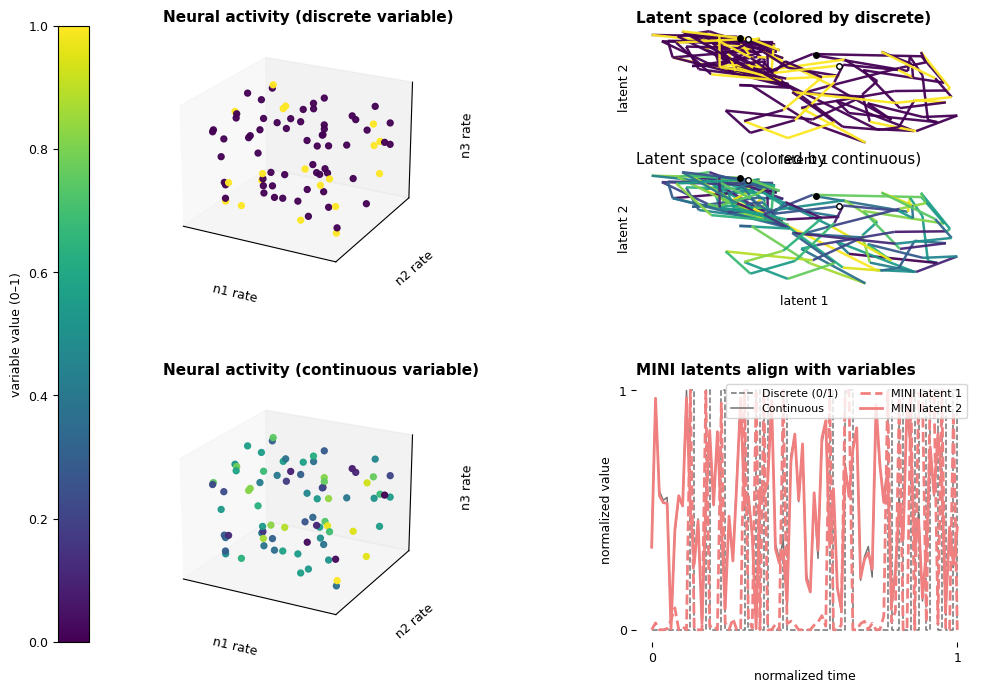

In [ ]:
# -------------------------------
# Constants / params
# -------------------------------
SEED = 42
N = 80
COLORMAP = "viridis"
RIGHT_COL_WIDTH = 0.9  # relative to left column (left=1.0, right<1.0)
FONT_SIZE = 9
TITLE_SIZE = 11
FIGSIZE = (12, 8)
DPI = 600

# Noise for MINI latents (no smoothing)
NOISE_DISC_MU, NOISE_DISC_SIG = 0.0, 0.04
NOISE_CONT_MU, NOISE_CONT_SIG = 0.0, 0.02

# Discrete prevalence
P_ON = 0.2

# -------------------------------
# Data generation
# -------------------------------
# rng = np.random.default_rng(SEED)
t = np.linspace(0, 20 * np.pi, N)


def rescale01(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x


# Neural rates (nonlinear mixes + noise), squashed to [0,1]
n1 = 0.8 * np.sin(2.1 * t) + 0.3 * np.sin(5.3 * t + 0.3) + 0.2 * rng.standard_normal(N)
n2 = 0.9 * np.cos(1.3 * t + 0.5) + 0.25 * np.sin(4.7 * t) + 0.2 * rng.standard_normal(N)
n3 = 0.7 * np.sin(1.7 * t - 0.8) + 0.35 * np.cos(3.2 * t) + 0.2 * rng.standard_normal(N)
n1r = rescale01(np.tanh(n1))
n2r = rescale01(np.tanh(n2))
n3r = rescale01(np.tanh(n3))

# Variables
disc = (rng.random(N) < P_ON).astype(int)
cont = 0.5 + 0.5 * (0.55 * np.sin(1.1 * t + 0.2) + 0.45 * np.sin(2.9 * t - 0.7))
cont += 0.02 * rng.standard_normal(N)
cont = np.clip(rescale01(cont), 0, 1)

# Two latent trajectories (nonlinear transforms + offsets)
latA_x = np.tanh(0.9 * n1r - 0.2 * n2r + 0.5 * n3r + 0.05 * np.sin(0.7 * t))
latA_y = np.tanh(-0.3 * n1r + 0.8 * n2r - 0.15 * n3r + 0.05 * np.cos(0.9 * t))
latB_x = np.tanh(0.6 * n1r - 0.5 * n2r + 0.6 * np.sin(0.5 * t)) + 1.2
latB_y = np.tanh(-0.4 * n1r + 0.7 * n3r + 0.6 * np.cos(0.6 * t)) - 0.6

# MINI latents (no smoothing; additive Gaussian noise, then clip to [0,1])
mini1 = np.clip(disc + rng.normal(NOISE_DISC_MU, NOISE_DISC_SIG, N), 0, 1)  # tracks discrete
mini2 = np.clip(cont + rng.normal(NOISE_CONT_MU, NOISE_CONT_SIG, N), 0, 1)  # tracks continuous


# Helper to draw colored trajectory as a continuous line
def add_colored_trajectory(ax, x, y, values=None, cmap=None, lw=1.8, vmin=0.0, vmax=1.0):
    pts = np.array([x, y]).T.reshape(-1, 1, 2)
    segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
    lc = LineCollection(segs, cmap=cmap, linewidth=lw, alpha=0.95)
    lc.set_array(values[:-1])
    lc.set_clim(vmin=vmin, vmax=vmax)
    ax.add_collection(lc)
    ax.plot(x, y, alpha=0)  # set limits
    return lc


# -------------------------------
# Figure & layout
# -------------------------------
plt.rcParams.update(
    {"font.size": FONT_SIZE, "axes.titlesize": TITLE_SIZE, "axes.labelsize": FONT_SIZE}
)
fig = plt.figure(figsize=FIGSIZE)
gs = fig.add_gridspec(2, 2, width_ratios=[1.0, RIGHT_COL_WIDTH], wspace=0.28, hspace=0.34)

# Left column: 3D neural activity (both using viridis)
ax_a = fig.add_subplot(gs[0, 0], projection="3d")
sa = ax_a.scatter(
    n1r, n2r, n3r, c=disc, cmap=COLORMAP, vmin=0, vmax=1, s=18, alpha=0.95, depthshade=False
)
ax_a.set_xlabel("n1 rate", labelpad=5)
ax_a.set_ylabel("n2 rate", labelpad=5)
ax_a.set_zlabel("n3 rate", labelpad=5)
ax_a.set_title("Neural activity (discrete variable)", loc="left", pad=3, fontweight="bold")
ax_a.view_init(22, -62)
ax_a.grid(False)
ax_a.set_xticks([])
ax_a.set_yticks([])
ax_a.set_zticks([])

ax_b = fig.add_subplot(gs[1, 0], projection="3d")
sb = ax_b.scatter(
    n1r, n2r, n3r, c=cont, cmap=COLORMAP, vmin=0, vmax=1, s=18, alpha=0.95, depthshade=False
)
ax_b.set_xlabel("n1 rate", labelpad=5)
ax_b.set_ylabel("n2 rate", labelpad=5)
ax_b.set_zlabel("n3 rate", labelpad=5)
ax_b.set_title("Neural activity (continuous variable)", loc="left", pad=3, fontweight="bold")
ax_b.view_init(22, -62)
ax_b.grid(False)
ax_b.set_xticks([])
ax_b.set_yticks([])
ax_b.set_zticks([])

# Top-right cell split into two stacked axes (identical latent spaces; different coloring)
gs_tr = gs[0, 1].subgridspec(2, 1, hspace=0.15)
ax_c1 = fig.add_subplot(gs_tr[0, 0])
ax_c2 = fig.add_subplot(gs_tr[1, 0])

# identical latent coordinates in both; color by discrete (top) and continuous (bottom)
m1 = add_colored_trajectory(ax_c1, latA_x, latA_y, values=disc, cmap=COLORMAP, vmin=0, vmax=1)
m1b = add_colored_trajectory(ax_c1, latB_x, latB_y, values=disc, cmap=COLORMAP, vmin=0, vmax=1)
for ax in [ax_c1]:
    ax.plot([latA_x[0]], [latA_y[0]], "o", ms=4, color="k")
    ax.plot([latA_x[-1]], [latA_y[-1]], "o", ms=4, mfc="w", mec="k")
    ax.plot([latB_x[0]], [latB_y[0]], "o", ms=4, color="k")
    ax.plot([latB_x[-1]], [latB_y[-1]], "o", ms=4, mfc="w", mec="k")
    ax.set_title("Latent space (colored by discrete)", loc="left", pad=2, fontweight="bold")

m2 = add_colored_trajectory(ax_c2, latA_x, latA_y, values=cont, cmap=COLORMAP, vmin=0, vmax=1)
m2b = add_colored_trajectory(ax_c2, latB_x, latB_y, values=cont, cmap=COLORMAP, vmin=0, vmax=1)
for ax in [ax_c2]:
    ax.plot([latA_x[0]], [latA_y[0]], "o", ms=4, color="k")
    ax.plot([latA_x[-1]], [latA_y[-1]], "o", ms=4, mfc="w", mec="k")
    ax.plot([latB_x[0]], [latB_y[0]], "o", ms=4, color="k")
    ax.plot([latB_x[-1]], [latB_y[-1]], "o", ms=4, mfc="w", mec="k")
    ax.set_title("Latent space (colored by continuous)", loc="left", pad=2)

# style for latent axes
for ax in [ax_c1, ax_c2]:
    ax.set_xlabel("latent 1")
    ax.set_ylabel("latent 2")
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)

# Bottom-right: time series
ax_d = fig.add_subplot(gs[1, 1])
time = np.linspace(0, 1, N)
ax_d.plot(
    time,
    disc,
    lw=1.1,
    color="0.45",
    linestyle="--",
    drawstyle="steps-post",
    label="Discrete (0/1)",
)
ax_d.plot(time, cont, lw=1.1, color="0.45", linestyle="-", label="Continuous")
lat_color = "#f08080"  # light red
ax_d.plot(time, mini1, lw=2.0, color=lat_color, linestyle="--", label="MINI latent 1")
ax_d.plot(time, mini2, lw=2.0, color=lat_color, linestyle="-", label="MINI latent 2")
ax_d.set_ylim(-0.05, 1.05)
ax_d.set_xlabel("normalized time")
ax_d.set_ylabel("normalized value")
ax_d.set_title("MINI latents align with variables", loc="left", pad=3, fontweight="bold")
ax_d.legend(ncol=2, fontsize=8, frameon=True, loc="upper right")
ax_d.set_yticks([0, 1.0])
ax_d.set_xticks([0, 1.0])
for s in ax_d.spines.values():
    s.set_visible(False)

# Shared colorbar to the LEFT for the viridis mapping (0..1)
sm = ScalarMappable(norm=Normalize(vmin=0, vmax=1), cmap=COLORMAP)
sm.set_array([])
cbar = fig.colorbar(sm, ax=fig.axes, location="left", fraction=0.05, pad=0.08)
cbar.set_label("variable value (0-1)")


In [60]:
def add_start_end_and_arrows(ax, x, y, n_arrows=8, edge_skip=5, arrow_kwargs=None):
    """
    Draw a white start marker, black end marker, and evenly spaced arrows
    indicating trajectory direction along (x(t), y(t)).

    Parameters
    ----------
    ax : matplotlib Axes
    x, y : 1D arrays of same length (trajectory coordinates)
    n_arrows : int, number of arrows to draw
    edge_skip : int, how many samples to skip at each end before placing arrows
    arrow_kwargs : dict, passed to annotate(..., arrowprops=arrow_kwargs)
    """
    if arrow_kwargs is None:
        arrow_kwargs = dict(arrowstyle="->", lw=0.8, alpha=0.7)

    # start (white) and end (black) markers
    ax.plot([x[0]], [y[0]], marker="o", ms=5, mfc="white", mec="black", zorder=5)
    ax.plot([x[-1]], [y[-1]], marker="o", ms=5, mfc="black", mec="black", zorder=5)

    # evenly spaced arrows along the path
    n = len(x)
    if n < 2:
        return
    i0 = max(0, edge_skip)
    i1 = max(i0 + 1, n - 2 - edge_skip)
    idxs = np.linspace(i0, i1, max(1, n_arrows), dtype=int)
    for i in idxs:
        ax.annotate("", xy=(x[i + 1], y[i + 1]), xytext=(x[i], y[i]), arrowprops=arrow_kwargs)


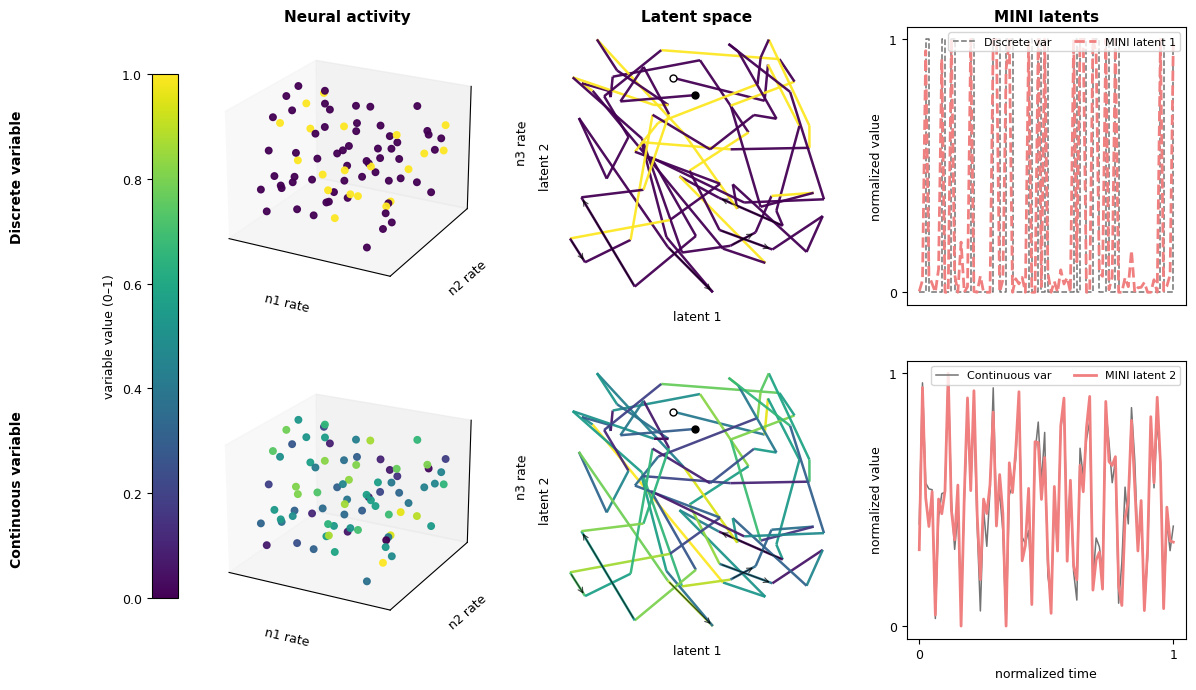

In [72]:
SEED = 42
N_POINTS = 80  # number of time points / samples
P_ON = 0.20  # discrete "on" prevalence

COLORMAP = "viridis"  # used for neural + latent space coloring
FIGSIZE = (12, 6.8)
DPI = 600

# Axis/marker styling
MARKER_SIZE_3D = 22
AXIS_LABELPAD = 3
VIEW_ELEV, VIEW_AZIM = 22, -62

# MINI latent noise (no smoothing)
NOISE_DISC = dict(mu=0.0, sigma=0.06)
NOISE_CONT = dict(mu=0.0, sigma=0.07)
VAR_COLOR = "0.45"  # gray for variables in MINI panels
LATENT_COLOR = "#f08080"  # light red for MINI latents

# Layout: column widths and whitespace paddings (EXPOSED knobs)
COL_WIDTHS = [1.0, 1.0, 1.0]  # 3 columns
COL_WSPACE = 0.25  # horizontal whitespace between columns
ROW_HSPACE = 0.2  # vertical whitespace between rows

# Save path (optional)
SAVE_PATH = "mini_intro_3x2.png"  # change or set to None to skip saving
# -------------------------------


# -------------------------------
# Data generation
# -------------------------------
# rng = np.random.default_rng(SEED)
t = np.linspace(0, 20 * np.pi, N_POINTS)


def rescale01(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x


# Neural rates (nonlinear mixes + noise), squashed to [0,1]
n1 = 0.8 * np.sin(2.1 * t) + 0.3 * np.sin(5.3 * t + 0.3) + 0.2 * rng.standard_normal(N_POINTS)
n2 = 0.9 * np.cos(1.3 * t + 0.5) + 0.25 * np.sin(4.7 * t) + 0.2 * rng.standard_normal(N_POINTS)
n3 = 0.7 * np.sin(1.7 * t - 0.8) + 0.35 * np.cos(3.2 * t) + 0.2 * rng.standard_normal(N_POINTS)
n1r = rescale01(np.tanh(n1))
n2r = rescale01(np.tanh(n2))
n3r = rescale01(np.tanh(n3))

# Variables
disc = (rng.random(N_POINTS) < P_ON).astype(int)
cont = 0.5 + 0.5 * (0.55 * np.sin(1.1 * t + 0.2) + 0.45 * np.sin(2.9 * t - 0.7))
cont += 0.02 * rng.standard_normal(N_POINTS)
cont = np.clip(rescale01(cont), 0, 1)

# Latent trajectories (two paths in the same 2D space)
latA_x = np.tanh(0.9 * n1r - 0.2 * n2r + 0.5 * n3r + 0.05 * np.sin(0.7 * t))
latA_y = np.tanh(-0.3 * n1r + 0.8 * n2r - 0.15 * n3r + 0.05 * np.cos(0.9 * t))
latB_x = (
    np.tanh(0.6 * n1r - 0.5 * n2r + 0.6 * np.sin(0.5 * t)) + 1.2
)  # offset so two curves don't overlap
latB_y = np.tanh(-0.4 * n1r + 0.7 * n3r + 0.6 * np.cos(0.6 * t)) - 0.6

# MINI latents (no smoothing; additive Gaussian noise; clipped to [0,1])
mini1 = np.clip(disc + rng.normal(NOISE_DISC["mu"], NOISE_DISC["sigma"], N_POINTS), 0, 1)
mini2 = np.clip(cont + rng.normal(NOISE_CONT["mu"], NOISE_CONT["sigma"], N_POINTS), 0, 1)


# -------------------------------
# Helpers
# -------------------------------
def colored_line(ax, x, y, values, cmap=COLORMAP, lw=1.8, vmin=0.0, vmax=1.0):
    """Add a line whose segments are colored by `values`."""
    pts = np.array([x, y]).T.reshape(-1, 1, 2)
    segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
    lc = LineCollection(segs, cmap=cmap, linewidth=lw, alpha=0.95)
    lc.set_array(values[:-1])
    lc.set_clim(vmin=vmin, vmax=vmax)
    ax.add_collection(lc)
    ax.plot(x, y, alpha=0)  # set limits without drawing
    return lc


def style_latent_axes(ax, title=None, is_top=False):
    ax.set_xlabel("latent 1")
    ax.set_ylabel("latent 2")
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)
    if title:
        ax.set_title(title, pad=4, fontweight="bold" if is_top else None)


# -------------------------------
# Figure & layout (3 columns × 2 rows)
# -------------------------------
plt.rcParams.update({"font.size": 9, "axes.titlesize": 11, "axes.labelsize": 9})
fig = plt.figure(figsize=FIGSIZE)
gs = fig.add_gridspec(2, 3, width_ratios=COL_WIDTHS, wspace=COL_WSPACE, hspace=ROW_HSPACE)

# Column headers (top row axis titles)
COL_TITLES = ["Neural activity", "Latent space", "MINI latents"]
ROW_TITLES = ["Discrete variable", "Continuous variable"]

# --- Column 1: Neural activity (3D)
ax_na_disc = fig.add_subplot(gs[0, 0], projection="3d")
ax_na_disc.scatter(
    n1r,
    n2r,
    n3r,
    c=disc,
    cmap=COLORMAP,
    vmin=0,
    vmax=1,
    s=MARKER_SIZE_3D,
    alpha=0.95,
    depthshade=False,
)
ax_na_disc.set_xlabel("n1 rate", labelpad=AXIS_LABELPAD)
ax_na_disc.set_ylabel("n2 rate", labelpad=AXIS_LABELPAD)
ax_na_disc.set_zlabel("n3 rate", labelpad=AXIS_LABELPAD)
ax_na_disc.set_title(COL_TITLES[0], pad=4, fontweight="bold")
ax_na_disc.view_init(VIEW_ELEV, VIEW_AZIM)
ax_na_disc.grid(False)
ax_na_disc.set_xticks([])
ax_na_disc.set_yticks([])
ax_na_disc.set_zticks([])

ax_na_cont = fig.add_subplot(gs[1, 0], projection="3d")
ax_na_cont.scatter(
    n1r,
    n2r,
    n3r,
    c=cont,
    cmap=COLORMAP,
    vmin=0,
    vmax=1,
    s=MARKER_SIZE_3D,
    alpha=0.95,
    depthshade=False,
)
ax_na_cont.set_xlabel("n1 rate", labelpad=AXIS_LABELPAD)
ax_na_cont.set_ylabel("n2 rate", labelpad=AXIS_LABELPAD)
ax_na_cont.set_zlabel("n3 rate", labelpad=AXIS_LABELPAD)
ax_na_cont.view_init(VIEW_ELEV, VIEW_AZIM)
ax_na_cont.grid(False)
ax_na_cont.set_xticks([])
ax_na_cont.set_yticks([])
ax_na_cont.set_zticks([])

# --- Column 2: Latent space (2D) – same geometry, different coloring per row
ax_lat_disc = fig.add_subplot(gs[0, 1])
# colored_line(ax_lat_disc, latA_x, latA_y, disc, cmap=COLORMAP, vmin=0, vmax=1)
# add_start_end_and_arrows(ax_lat_disc, latA_x, latA_y, n_arrows=6)

colored_line(ax_lat_disc, latB_x, latB_y, disc, cmap=COLORMAP, vmin=0, vmax=1)
add_start_end_and_arrows(ax_lat_disc, latB_x, latB_y, n_arrows=6)

style_latent_axes(ax_lat_disc, title=COL_TITLES[1], is_top=True)

ax_lat_cont = fig.add_subplot(gs[1, 1])
# colored_line(ax_lat_cont, latA_x, latA_y, cont, cmap=COLORMAP, vmin=0, vmax=1)
# add_start_end_and_arrows(ax_lat_cont, latA_x, latA_y, n_arrows=6)

colored_line(ax_lat_cont, latB_x, latB_y, cont, cmap=COLORMAP, vmin=0, vmax=1)
add_start_end_and_arrows(ax_lat_cont, latB_x, latB_y, n_arrows=6)

style_latent_axes(ax_lat_cont)

# --- Column 3: MINI latents (time series) – split into discrete vs continuous
time = np.linspace(0, 1, N_POINTS)

ax_mini_disc = fig.add_subplot(gs[0, 2])
ax_mini_disc.plot(
    time,
    disc,
    lw=1.1,
    color=VAR_COLOR,
    linestyle="--",
    drawstyle="steps-post",
    label="Discrete var",
)
ax_mini_disc.plot(time, mini1, lw=2.0, color=LATENT_COLOR, linestyle="--", label="MINI latent 1")
ax_mini_disc.set_ylim(-0.05, 1.05)
ax_mini_disc.set_xticks([])
ax_mini_disc.set_yticks([0, 1.0])
ax_mini_disc.set_ylabel("normalized value")
ax_mini_disc.set_title(COL_TITLES[2], pad=4, fontweight="bold")
ax_mini_disc.legend(loc="upper right", ncol=2, fontsize=8, frameon=True)

ax_mini_cont = fig.add_subplot(gs[1, 2])
ax_mini_cont.plot(time, cont, lw=1.1, color=VAR_COLOR, linestyle="-", label="Continuous var")
ax_mini_cont.plot(time, mini2, lw=2.0, color=LATENT_COLOR, linestyle="-", label="MINI latent 2")
ax_mini_cont.set_ylim(-0.05, 1.05)
ax_mini_cont.set_xlabel("normalized time")
ax_mini_cont.set_yticks([0, 1.0])
ax_mini_cont.set_xticks([0, 1.0])
ax_mini_cont.set_ylabel("normalized value")
ax_mini_cont.legend(loc="upper right", ncol=2, fontsize=8, frameon=True)

# Row headers on the left margin
fig.text(
    0.01, 0.73, ROW_TITLES[0], rotation=90, va="center", ha="left", fontsize=10, weight="bold"
)
fig.text(
    0.01, 0.27, ROW_TITLES[1], rotation=90, va="center", ha="left", fontsize=10, weight="bold"
)

# One shared viridis colorbar (0..1) for Neural + Latent columns
sm = ScalarMappable(norm=Normalize(vmin=0, vmax=1), cmap=COLORMAP)
sm.set_array([])
cbar = fig.colorbar(
    sm,
    ax=[ax_na_disc, ax_na_cont, ax_lat_disc, ax_lat_cont],
    location="left",
    fraction=0.05,
    pad=0.5,
)
cbar.set_label("variable value (0–1)")

# Final spacing (uses the exposed COL_WSPACE / ROW_HSPACE)
fig.subplots_adjust(
    left=0.175, right=0.99, top=0.95, bottom=0.05, wspace=COL_WSPACE, hspace=ROW_HSPACE
)


In [73]:
# Export as svg
fig.savefig("intro_fig.svg", dpi=DPI, bbox_inches="tight", format="svg")